In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functorch import vmap
import matplotlib.pyplot as plt
import torch.nn.functional as F

from caustic.utils import get_meshgrid
from caustic_v2 import *

thx, thy = get_meshgrid(0.05, 100, 100)

My goal in this notebook and `caustic_v2.py` is to clarify the core concepts in Alex prototyping: marking which model parameters in the input `x` are static versus dynamic, properly funneling arguments through model components and flexibly converting between representing parameters using a `kwargs` `dict`, a list of `args` and flattened tensors.

Similarly to Alex, my implementation has a `Param` class (analogous to `nn.Parameter`) that tracks whether a given parameter is static or dynamic. I also have a `Parametrized` classes (analogous to `nn.Module`) that keeps track of its parameters and any members that are themselves `Parametrized`. This class can unpack `x` to retrieve its parameters, and can repack `x` into a `dict` that forwards properly to any `Parametrized` members.

One of the main differences is that I've removed some of the "probabilistic programming" logic (constraints, transforms and `log_abs_det_jacobian` calculations).

I've also removed `ParameterList` and `ParameterCollection`: this logic is now pretty much contained in `Parametrized`. The idea now is to recursively register parameters of children:

In [20]:
class Nested1(Parametrized):
    def __init__(self, p1=None, name="n1"):
        super().__init__(name)
        self.add_param("p1", p1)

    def __call__(self, x):
        p1 = self.unpack(x)
        print(f"p1 is {p1}")


class Nested2(Parametrized):
    def __init__(self, n1, p2=None, name="n2"):
        super().__init__(name)
        self.add_param("p2", p2)
        self.n1 = n1

    def __call__(self, x):
        p2 = self.unpack(x)
        print(f"p2 is {p2}")


class Nested3(Parametrized):
    def __init__(self, n1, n2, p3=None, name="n3"):
        super().__init__(name)
        self.add_param("p3", p3)
        self.n1 = n1
        self.n2 = n2

    def __call__(self, x):
        p3 = self.unpack(x)
        self.n1(x)
        self.n2(x)
        print(f"p3 is {p3}")

In [35]:
n1 = Nested1(torch.tensor(1.0))
n2 = Nested2(n1)
n3 = Nested3(n1, n2)
print("model:", n3, "\n")
print("repacked args:", n3.x_to_dict(torch.tensor([3.0, 2.0])), "\n")
print("model output:")
n3(n3.x_to_dict(torch.tensor([3.0, 2.0])))

model: Nested3(
    name='n3',
    static params=['p1'],
    dynamic params=['p3', 'p2']
) 

repacked args: {'n3': tensor([3.]), 'n1': tensor([]), 'n2': tensor([2.])} 

model output:
p1 is [tensor(1.)]
p2 is [tensor(2.)]
p3 is [tensor(3.)]


This cell initializes some lensing model components, evaluates them and shows they still work fine with `vmap`.

In [54]:
src = Sersic("src", torch.tensor(1.0), torch.tensor(0.0))
print(src, "\n")

x_src = torch.tensor([0.7, pi / 6, 4.0, 5.0, 1.0])
print("evaluating src:", src.brightness(1.0, 2.0, src.x_to_dict(x_src)), "\n")

x_src_batch = x_src.repeat(4, 1) + torch.randn(4, 5) * 0.05
print(
    "vmap src:",
    vmap(src.brightness, (None, None, 0))(1.0, 2.0, src.x_to_dict(x_src_batch)),
    "\n",
)

cosmo = FlatLambdaCDMCosmology("cosmo", h0=None)
print(cosmo, "\n")

print(
    "comoving distance:",
    cosmo.comoving_dist(torch.tensor(1.0), cosmo.x_to_dict([1.1 * h0_default])),
    "\n",
)

cosmo = FlatLambdaCDMCosmology("cosmo", h0=None)
sie = SIE("sie", cosmo, z_l=torch.tensor(1.1))
print(sie, "\n")

x_sie = torch.tensor([0.2, 0.01, 0.7, 0.3, 1.2, 0.7])  # last entry is H0
print(
    "running alpha_hat (which calls cosmology methods):",
    sie.alpha_hat(thx, thy, torch.tensor(0.8), sie.x_to_dict(x_sie))[0].shape,
    "\n",
)

x_sie_batch = x_sie.repeat(10, 1)
print(
    "vmap shape check:",
    vmap(sie.alpha, (None, None, None, 0))(
        thx, thy, torch.tensor(0.8), sie.x_to_dict(x_sie_batch)
    )[0].shape,
    "\n",
)

Sersic(
    name='src',
    static params=['thx0', 'thy0', 's'],
    dynamic params=['q', 'phi', 'index', 'th_e', 'I_e']
) 

evaluating src: tensor(4.0546) 

vmap src: tensor([3.9431, 4.6207, 4.0885, 4.1725]) 

FlatLambdaCDMCosmology(
    name='cosmo',
    static params=['rho_cr_0', 'Om0'],
    dynamic params=['h0']
) 

comoving distance: tensor(3089.6018) 

SIE(
    name='sie',
    static params=['z_l', 's', 'rho_cr_0', 'Om0'],
    dynamic params=['thx0', 'thy0', 'q', 'phi', 'b', 'h0']
) 

running alpha_hat (which calls cosmology methods): torch.Size([100, 100]) 

vmap shape check: torch.Size([10, 100, 100]) 



Here's what a simple simulator looks like.

In [40]:
class Simulator(Parametrized):
    def __init__(
        self,
        res,
        n_pix,
        lens,
        src,
        z_s=None,
        upsample_factor=4,
        name: str = "simulator",
    ):
        super().__init__(name)
        self.lens = lens
        self.src = src
        self.add_param("z_s", z_s)
        self.upsample_factor = upsample_factor

        self._thx_fine, self._thy_fine = get_meshgrid(
            res / upsample_factor, n_pix * upsample_factor, n_pix * upsample_factor
        )
        self.thx, self.thy = get_meshgrid(res, n_pix, n_pix)

    def forward(self, x):
        x = self.x_to_dict(x)

        z_s = self.unpack(x)
        bx, by = self.lens.raytrace(self._thx_fine, self._thy_fine, z_s, x)
        mu_fine = self.src.brightness(bx, by, x)
        return F.avg_pool2d(mu_fine[None, None], self.upsample_factor)[0, 0]

Simulator(
    name='simulator',
    static params=['z_s', 'z_l', 'thx0', 'thy0', 'q', 'phi', 'b', 's', 'rho_cr_0', 'Om0', 'index', 'th_e', 'I_e'],
    dynamic params=['h0', 'thx0', 'thy0']
) 

testing x size error checking:
caught exception:  0 flattened dynamic args were passed, but 3 are required 

running with valid argument vector

vmap shape check: torch.Size([10, 50, 50])


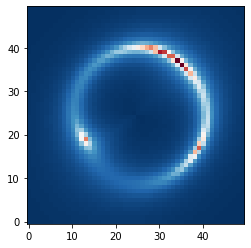

In [51]:
# Set up cosmology, marking H0 as dynamic
cosmo = FlatLambdaCDMCosmology("cosmo", h0=None)

# Static SIE args: thx0, thy0, q, phi, b, z_l
x_lens = torch.tensor([0.0, 0.0, 0.8, pi / 6, 1.5, 0.8])
sie = SIE("sie", cosmo, *x_lens)

# Static Sersic args: q, phi, index, th_e, I_e
x_src = torch.tensor([0.6, pi / 4, 4.0, 2.5, 1.0])
src = Sersic("src", None, None, *x_src)

sim = Simulator(0.1, 50, sie, src, torch.tensor(0.8))
print(sim, "\n")

print("testing x size error checking:")
x = torch.tensor([])
try:
    sim.x_to_dict(x)
except ValueError as e:
    print("caught exception: ", e, "\n")

print("running with valid argument vector")
x = torch.tensor([0.7, 0.13, 0.04])
plt.imshow(sim.forward(x), origin="lower", cmap="RdBu_r")
print()

print("vmap shape check:", vmap(sim.forward)(x.repeat(10, 1)).shape)

There are a few things I'm not clear on with this approach.
- In this approach, I don't think we can't run the same model component on different parameters: through the component's name, it's tied to one set of parameters in `x`. This makes it expensive to do things like include multiple `KappaGrid` lenses: each set of `Param`s must be associated with one `KappaGrid`, so we need to create a redundant set of kernels.
- How should we handle `Param`s like `z_s`? In what's above, I made this a parameter of the simulator, but that means we have to explicitly pass it to `raytrace`. How will this generalize?
- Is it confusing that names of `Param`s and `Parametrized` don't match the names of the attributes they're bound to?